In [1]:
"""
https://github.com/dfki-ric-underactuated-lab/torque_limited_simple_pendulum
https://github.com/turcato-niccolo/double_pendulum
"""
import numpy as np
from double_pendulum.simulation.simulation import Simulator
from double_pendulum.controller.abstract_controller import AbstractController
from double_pendulum.controller.combined_controller import CombinedController
from double_pendulum.controller.lqr.lqr_controller import LQRController_nonsymbolic
from double_pendulum.model.model_parameters import model_parameters

import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

%matplotlib inline 

In [2]:
class PendulumPlant:
    def __init__(self, mass=1.0, length=0.5, damping=0.1, gravity=9.81,
                 cfric=0.0, inertia=None, torque_limit=np.inf):

        """
        The PendulumPlant class contains the kinematics and dynamics
        of the simple pendulum.

        The state of the pendulum in this class is described by
            state = [angle, angular velocity]
            (array like with len(state)=2)
            in units: rad and rad/s
        The zero state of the angle corresponds to the pendulum hanging down.
        The plant expects an actuation input (tau) either as float or
        array like in units Nm.
        (in which case the first entry is used (which should be a float))

        Parameters
        ----------
        mass : float, default=1.0
            pendulum mass, unit: kg
        length : float, default=0.5
            pendulum length, unit: m
        damping : float, default=0.1
            damping factor (proportional to velocity), unit: kg*m/s
        gravity : float, default=9.81
            gravity (positive direction points down), unit: m/s^2
        coulomb_fric : float, default=0.0
            friction term, (independent of magnitude of velocity), unit: Nm
        inertia : float, default=None
            inertia of the pendulum (defaults to point mass inertia)
            unit: kg*m^2
        torque_limit: float, default=np.inf
            maximum torque that the motor can apply, unit: Nm
        """

        self.m = mass
        self.l = length
        self.b = damping
        self.g = gravity
        self.coulomb_fric = cfric
        if inertia is None:
            self.inertia = mass * length * length
        else:
            self.inertia = inertia

        self.torque_limit = [torque_limit]

        self.dof = 1
        self.n_actuators = 1
        self.base = [0, 0]
        self.n_links = 1
        self.workspace_range = [[-1.2 * self.l, 1.2 * self.l],
                                [-1.2 * self.l, 1.2 * self.l]]

    def load_params_from_file(self, filepath):
        """
        Load the pendulum parameters from a yaml file.

        Parameters
        ----------
        filepath : string
            path to yaml file
        """

        with open(filepath, 'r') as yaml_file:
            params = yaml.safe_load(yaml_file)
        self.m = params["mass"]
        self.l = params["length"]
        self.b = params["damping"]
        self.g = params["gravity"]
        self.coulomb_fric = params["coulomb_fric"]
        self.inertia = params["inertia"]
        self.torque_limit = params["torque_limit"]
        self.dof = params["dof"]
        self.n_actuators = params["n_actuators"]
        self.base = params["base"]
        self.n_links = params["n_links"]
        self.workspace_range = [[-1.2 * self.l, 1.2 * self.l],
                                [-1.2 * self.l, 1.2 * self.l]]

    def forward_kinematics(self, pos):

        """
        Computes the forward kinematics.

        Parameters
        ----------
        pos : float, angle of the pendulum

        Returns
        -------
        list : A list containing one list (for one end-effector)
              The inner list contains the x and y coordinates
              for the end-effector of the pendulum
        """

        ee_pos_x = float(self.l * np.sin(pos))
        ee_pos_y = float(-self.l * np.cos(pos))
        return [[ee_pos_x, ee_pos_y]]

    def inverse_kinematics(self, ee_pos):

        """
        Comutes inverse kinematics

        Parameters
        ----------
        ee_pos : array like,
            len(state)=2
            contains the x and y position of the end_effector
            floats, units: m

        Returns
        -------
        pos : float
            angle of the pendulum, unit: rad
        """

        pos = np.arctan2(ee_pos[0] / self.l, ee_pos[1] / (-1.0 * self.l))
        return pos

    def forward_dynamics(self, state, tau):

        """
        Computes forward dynamics

        Parameters
        ----------
        state : array like
            len(state)=2
            The state of the pendulum [angle, angular velocity]
            floats, units: rad, rad/s
        tau : float
            motor torque, unit: Nm

        Returns
        -------
            - float, angular acceleration, unit: rad/s^2
        """

        torque = np.clip(tau, -np.asarray(self.torque_limit),
                         np.asarray(self.torque_limit))

        accn = (torque - self.m * self.g * self.l * np.sin(state[0]) -
                self.b * state[1] -
                np.sign(state[1]) * self.coulomb_fric) / self.inertia
        return accn

    def inverse_dynamics(self, state, accn):

        """
        Computes inverse dynamics

        Parameters
        ----------
        state : array like
            len(state)=2
            The state of the pendulum [angle, angular velocity]
            floats, units: rad, rad/s
        accn : float
            angular acceleration, unit: rad/s^2

        Returns
        -------
        tau : float
            motor torque, unit: Nm
        """

        tau = accn * self.inertia + \
              self.m * self.g * self.l * np.sin(state[0]) + \
              self.b * state[1] + np.sign(state[1]) * self.coulomb_fric
        return tau

    def rhs(self, t, state, tau):

        """
        Computes the integrand of the equations of motion.

        Parameters
        ----------
        t : float
            time, not used (the dynamics of the pendulum are time independent)
        state : array like
            len(state)=2
            The state of the pendulum [angle, angular velocity]
            floats, units: rad, rad/s
        tau : float or array like
            motor torque, unit: Nm

        Returns
        -------
        res : array like
              the integrand, contains [angular velocity, angular acceleration]
        """

        if isinstance(tau, (list, tuple, np.ndarray)):
            torque = tau[0]
        else:
            torque = tau

        accn = self.forward_dynamics(state, torque)

        res = np.zeros(2 * self.dof)
        res[0] = state[1]
        res[1] = accn
        return res

    def potential_energy(self, state):
        Epot = self.m * self.g * self.l * (1 - np.cos(state[0]))
        return Epot

    def kinetic_energy(self, state):
        Ekin = 0.5 * self.m * (self.l * state[1]) ** 2.0
        return Ekin

    def total_energy(self, state):
        E = self.potential_energy(state) + self.kinetic_energy(state)
        return E


In [4]:
# Parameters of the dynamical models
plant_parameters = {
    'mass': 0.57288,
    'length': 0.5,
    'damping': 0.15,
    'gravity': 9.81,
    'torque_limit': 2.25,
    'cfric': 0.4
}

# Plant Object
pendulum = PendulumPlant(**plant_parameters)

# Sampling Time
dt = 0.05 # 20Hz

# Simulator Object
sim = Simulator(pendulum, integrator_name='odeint')

# policy/controller
class DummyController(AbstractController):
    def get_control_output_(self, x, t=None):
        return [plant_parameters['torque_limit']]


dummy_policy = DummyController(dof=1)

x0 = np.array([0., 0.])

t, x, u = sim.simulate_and_animate(0.0, x0, 10., dt, controller=dummy_policy, save_video=True, anim_dt=dt)

t = np.array(t)
x = np.array(x)
u = np.array(u)

Saving video to pendulum_swingup.mp4
Saving video done.


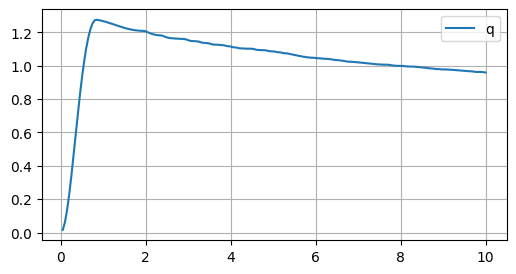

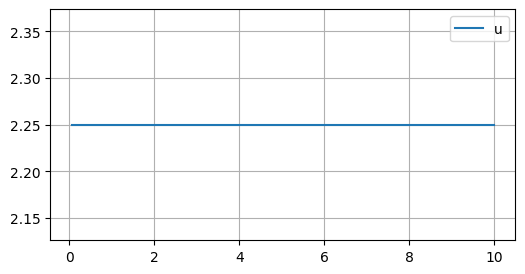

In [5]:
plt.figure(figsize=(6,3))
plt.plot(t, x[:, 0], label='q')
plt.legend()
plt.grid()
plt.figure(figsize=(6,3))
plt.plot(t, u, label='u')
plt.legend()
plt.grid()

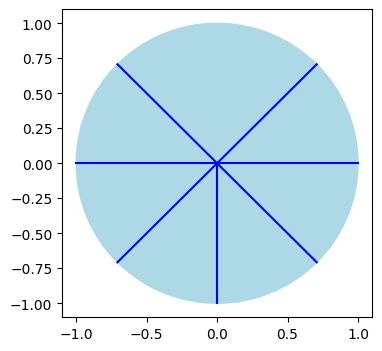

In [7]:
ACTIONS = np.array([plant_parameters['torque_limit'], -plant_parameters['torque_limit']])
q_1 = np.pi / 4
STATES = np.vstack([np.arange(0, np.pi-q_1, q_1), np.arange(q_1, np.pi, q_1)]).T
STATES = np.vstack([STATES, np.array([np.pi-q_1, np.pi+q_1])])
STATES = np.vstack([STATES, np.vstack([np.arange(np.pi+q_1, 2*np.pi, q_1), np.arange(np.pi+2*q_1, 2*np.pi+q_1, q_1)]).T])

plt.figure('STATE quantization', figsize=(4,4))
plt.gca().add_patch(plt.Circle((0., 0.), 1., color='lightblue')) 
for i in range(STATES.shape[0]):
    plt.plot([0., np.cos(STATES[i, 0] -np.pi/2)], [0., np.sin(STATES[i, 0] -np.pi/2)], color='b')


# sign of velocity +1 positive, -1 negative
pos_vel = np.ones((STATES.shape[0],1))
neg_vel = -np.ones((STATES.shape[0],1))
STATES = np.vstack([np.hstack([STATES, pos_vel]), np.hstack([STATES, neg_vel])]) # 16 states

FIX_POLICY = np.zeros((STATES.shape[0]))
for i in range((STATES.shape[0])):
    if STATES[i][2] >= 0:
        FIX_POLICY[i] = ACTIONS[0] # push anticlock-wise
    else:
        FIX_POLICY[i] = ACTIONS[1] # push clock-wise


In [8]:
print(STATES)
print(FIX_POLICY)

[[ 0.          0.78539816  1.        ]
 [ 0.78539816  1.57079633  1.        ]
 [ 1.57079633  2.35619449  1.        ]
 [ 2.35619449  3.92699082  1.        ]
 [ 3.92699082  4.71238898  1.        ]
 [ 4.71238898  5.49778714  1.        ]
 [ 5.49778714  6.28318531  1.        ]
 [ 0.          0.78539816 -1.        ]
 [ 0.78539816  1.57079633 -1.        ]
 [ 1.57079633  2.35619449 -1.        ]
 [ 2.35619449  3.92699082 -1.        ]
 [ 3.92699082  4.71238898 -1.        ]
 [ 4.71238898  5.49778714 -1.        ]
 [ 5.49778714  6.28318531 -1.        ]]
[ 2.25  2.25  2.25  2.25  2.25  2.25  2.25 -2.25 -2.25 -2.25 -2.25 -2.25
 -2.25 -2.25]


In [9]:
def get_state_index(s):
    q, dq = s.tolist()
    
    while q < 0:
        q += 2*np.pi
    while q > 2*np.pi:
        q -= 2*np.pi
    
    if np.sign(dq) == 0:
        dq += 0.1 #  arbitrary

    for i in range(len(STATES)):
        s_tile = STATES[i]
        if s_tile[0] <= q <= s_tile[1] and np.sign(dq) == s_tile[2]:
            return i
    raise Exception('Cannot find state idx')
    
    
def get_action_index(a):
    return np.argmin(np.abs(ACTIONS - a))


class PolicyController(AbstractController):
    def __init__(self, POLICY, dof=1):
        self.POLICY = POLICY
        super().__init__(dof=dof)

    def get_control_output_(self, x, t=None):
        return [self.POLICY[get_state_index(x)]]

class PController(AbstractController):
    def __init__(self, P=10., dof=1):
        self.P = P
        super().__init__(dof=dof)
    def get_control_output_(self, x, t=None):
        if x[0] < 0:
            x += 2*np.pi
            
        return [self.P * (np.pi - x[0])]

In [10]:
stabilization_controller = PController(dof=1)

q_switch = np.pi - q_1 # rad
print(q_switch)
condition_policy = lambda t, x: abs(x[0]) < q_switch
condition_stabilization = lambda t, x: abs(x[0]) >= q_switch

controller_fix_policy = PolicyController(FIX_POLICY, dof=1)



2.356194490192345


Saving video to pendulum_swingup.mp4
Switching to Controller  2 at x= [-8.5288725  11.47353357] t= 30.00000000000029
Switching to Controller  1 at x= [-1.9634343   9.20462216] t= 30.5500000000003
Switching to Controller  2 at x= [2.37816894 9.17302105] t= 30.950000000000305
Saving video done.


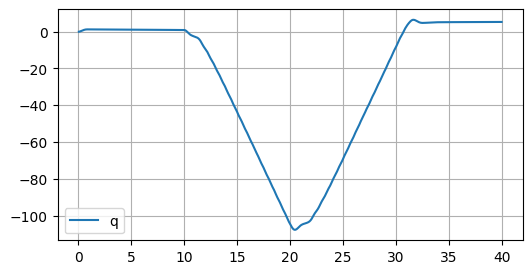

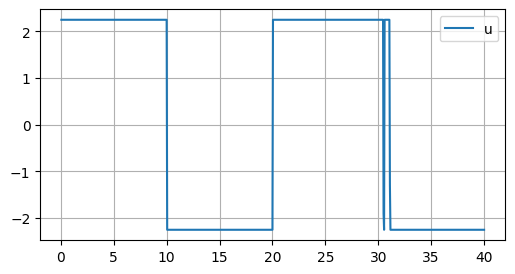

In [14]:
# Test Fixed policy controller

x0 = np.array([0., 0.])
comb_controller = CombinedController(controller1=controller_fix_policy, controller2=stabilization_controller,
                                 condition1=condition_policy, condition2=condition_stabilization,
                                 verbose=True, dof=1)
t, x, u = sim.simulate_and_animate(0.0, x0, 10., dt, controller=comb_controller, save_video=True, anim_dt=dt)

t = np.array(t)
x = np.array(x)
u = np.array(u)

plt.figure(figsize=(6,3))
plt.plot(t, x[:, 0], label='q')
plt.legend()
plt.grid()
plt.figure(figsize=(6,3))
plt.plot(t, u, label='u')
plt.legend()
plt.grid()

In [18]:
# Simulation with policy 

def simulate(controller, sim, x0, T=3., dt=0.02, reward_type='normal'):
    comb_controller = CombinedController(controller1=controller, controller2=stabilization_controller,
                                     condition1=condition_policy, condition2=condition_stabilization,
                                     verbose=False, dof=controller.dof)
    t, x, u, _ = sim.rollout(x0, comb_controller, T, dt, noise=[0.]*2)
    
    active_list = comb_controller.active_list    
    stab_ctrl_idxs = list(map(bool,active_list))
    
    
    u = [get_action_index(action) for action in u.tolist()]
    if reward_type == 'shaping':
        rewards = -np.abs(np.abs(x[:, 0]) - np.pi) # Arbitrary
    elif reward_type == 'normal':
        rewards = -np.ones_like(x[:, 0])
    else:
        raise NotImplemented()
        
    rewards[stab_ctrl_idxs] = +1 
    
    x = [get_state_index(x[i, :]) for i in range(x.shape[0])]

    
    return x, u, rewards.tolist()
    

In [19]:
# Monte Carlo Sample with On-Policy
def monte_carlo_on_policy(sim, controller, episodes, reward_type='normal'):
    states_actions = np.zeros((STATES.shape[0], ACTIONS.shape[0]))
    states_actions_count = np.ones((STATES.shape[0], ACTIONS.shape[0]))
    
    for i in tqdm(range(0, episodes)):
        x0 = np.random.normal([0.]*2, [10e-10]*2)
        x, u, rewards = simulate(controller, sim, x0, reward_type=reward_type)
        G = 0
        for state, action, reward in zip(x[::-1], u[::-1], rewards[::-1]):
            G += reward
            states_actions[state, action] += G
            states_actions_count[state, action] += 1
            
    # return the mean of the returns
    return states_actions / states_actions_count, states_actions_count

In [20]:
state_action_on_policy, states_actions_count = monte_carlo_on_policy(sim, controller_fix_policy, episodes=10, reward_type='normal')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.44it/s]


[[ 8.61437908  0.        ]
 [27.14482759  0.        ]
 [62.92682927  0.        ]
 [33.0292887  31.26829268]
 [ 0.          0.        ]
 [35.6097561   0.        ]
 [35.44827586  0.        ]
 [ 0.         41.89473684]
 [ 0.         35.90163934]
 [ 0.          0.        ]
 [39.23741007 37.71428571]
 [ 0.         63.44262295]
 [ 0.         32.08547009]
 [ 0.         15.09677419]]
[[153.   1.]
 [145.   1.]
 [ 41.   1.]
 [239. 123.]
 [  1.   1.]
 [ 41.   1.]
 [ 29.   1.]
 [  1.  38.]
 [  1.  61.]
 [  1.   1.]
 [139. 203.]
 [  1.  61.]
 [  1. 117.]
 [  1. 124.]]


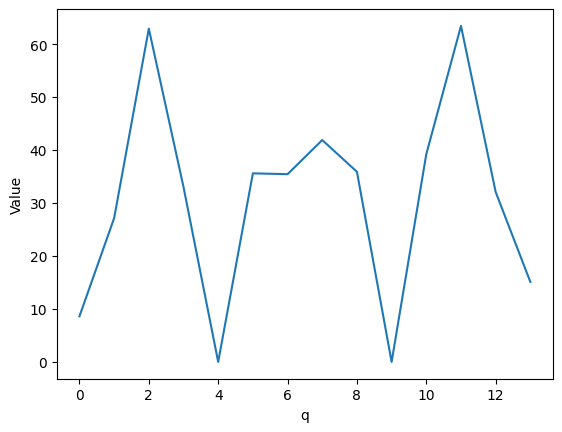

[154. 146.  42. 362.   2.  42.  30.  39.  62.   2. 342.  62. 118. 125.]


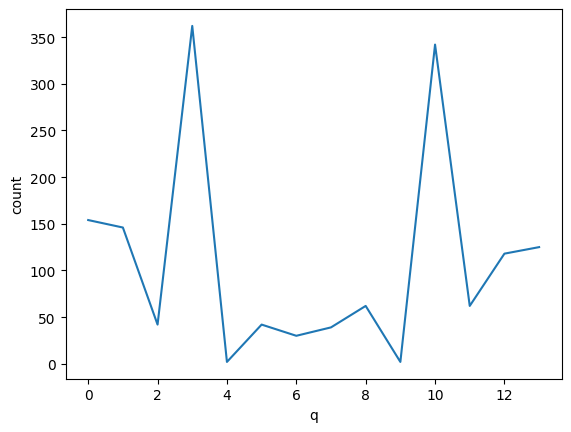

In [21]:
print(state_action_on_policy)
print(states_actions_count)
state = np.max(state_action_on_policy, axis=-1)

plt.figure('Estimate of value function')
plt.plot(state)
plt.ylabel('Value')
plt.xlabel('q')
plt.show()
plt.close()

state_cnt = np.sum(states_actions_count, axis=-1)
print(state_cnt)

plt.figure('Visited states')
plt.plot(state_cnt)
plt.ylabel('count')
plt.xlabel('q')
plt.show()
plt.close()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.70it/s]


[[10.85410765  0.        ]
 [29.06847254  0.        ]
 [64.36590437  0.        ]
 [34.87745975 34.93540856]
 [ 0.          0.        ]
 [36.42411642  0.        ]
 [40.66451613  0.        ]
 [ 0.         40.63690476]
 [ 0.         36.42994242]
 [ 0.          0.        ]
 [36.52164009 35.79085873]
 [ 0.         64.37619962]
 [ 0.         30.06127258]
 [ 0.         12.26894502]]
[[1.412e+03 1.000e+00]
 [1.329e+03 1.000e+00]
 [4.810e+02 1.000e+00]
 [2.236e+03 1.285e+03]
 [1.000e+00 1.000e+00]
 [4.810e+02 1.000e+00]
 [3.100e+02 1.000e+00]
 [1.000e+00 3.360e+02]
 [1.000e+00 5.210e+02]
 [1.000e+00 1.000e+00]
 [1.317e+03 2.166e+03]
 [1.000e+00 5.210e+02]
 [1.000e+00 1.273e+03]
 [1.000e+00 1.346e+03]]


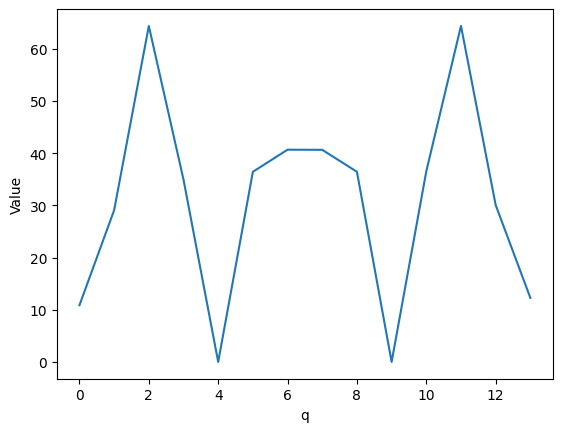

[1.413e+03 1.330e+03 4.820e+02 3.521e+03 2.000e+00 4.820e+02 3.110e+02
 3.370e+02 5.220e+02 2.000e+00 3.483e+03 5.220e+02 1.274e+03 1.347e+03]


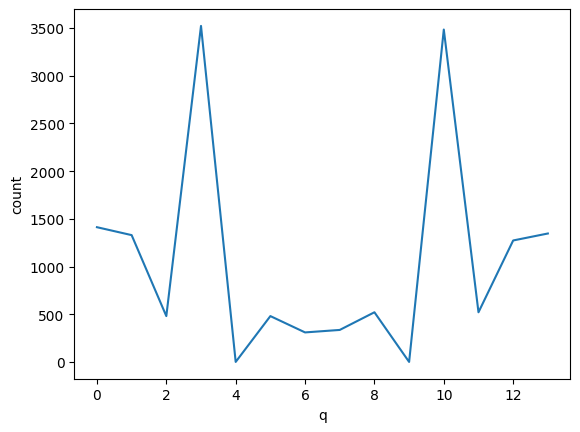

In [22]:
state_action_on_policy, states_actions_count = monte_carlo_on_policy(sim, controller_fix_policy, episodes=100, reward_type='normal')

print(state_action_on_policy)
print(states_actions_count)
state = np.max(state_action_on_policy, axis=-1)

plt.figure('Estimate of value function')
plt.plot(state)
plt.ylabel('Value')
plt.xlabel('q')
plt.show()
plt.close()

state_cnt = np.sum(states_actions_count, axis=-1)
print(state_cnt)

plt.figure('Visited states')
plt.plot(state_cnt)
plt.ylabel('count')
plt.xlabel('q')
plt.show()
plt.close()

Saving video to pendulum_swingup.mp4
Saving video done.


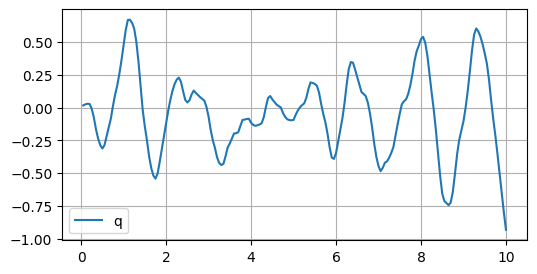

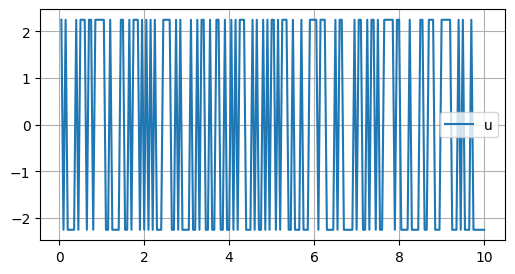

In [47]:
class RandomController(AbstractController):
    def __init__(self, dof=1):
        super().__init__(dof=dof)
        
    def get_control_output_(self, x, t=None):
        return [ACTIONS[np.random.randint(ACTIONS.shape[0])] for _ in range(self.dof)]

np.random.seed(3)

rand_policy = RandomController()

x0 = np.array([0., 0.])
sim = Simulator(pendulum, integrator_name='odeint')
t, x, u = sim.simulate_and_animate(t0=0.0, x0=x0, tf=10., dt=dt, controller=rand_policy, save_video=True, anim_dt=dt)

t = np.array(t)

x = np.array(x)
u = np.array(u)

plt.figure(figsize=(6,3))
plt.plot(t, x[:, 0], label='q')
plt.grid()
plt.legend()
plt.figure(figsize=(6,3))
plt.plot(t, u, label='u')
plt.legend()
plt.grid()


  3%|█████▍                                                                                                                                                                                | 3/100 [00:00<00:11,  8.13it/s]/home/niccoloturcato/anaconda3/envs/pytorch/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.34it/s]

[[-75.45869776 -77.59650873]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [-71.74899713 -73.99539701]
 [-70.20586544 -70.10461881]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [-81.15815568 -81.74803562]]
[[2.058e+03 2.005e+03]
 [1.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [1.745e+03 1.738e+03]
 [1.739e+03 1.797e+03]
 [1.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.017e+03 1.909e+03]]


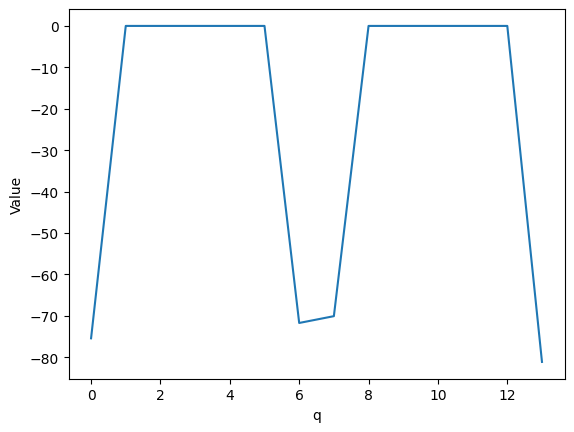

[4.063e+03 2.000e+00 2.000e+00 2.000e+00 2.000e+00 2.000e+00 3.483e+03
 3.536e+03 2.000e+00 2.000e+00 2.000e+00 2.000e+00 2.000e+00 3.926e+03]


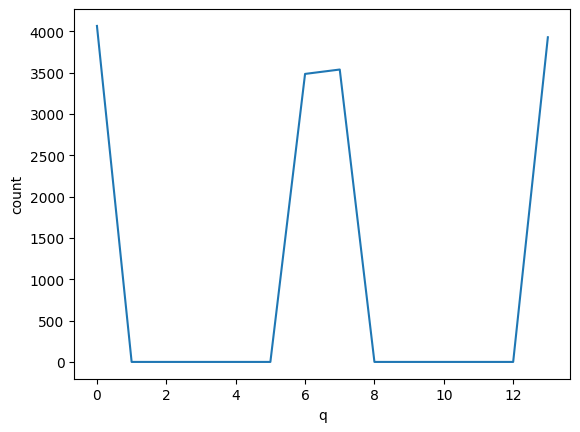

In [43]:

state_action_on_policy, states_actions_count = monte_carlo_on_policy(sim, rand_policy, episodes=100, reward_type='normal')

print(state_action_on_policy)
print(states_actions_count)
state = np.max(state_action_on_policy, axis=-1)

plt.figure('Estimate of value function')
plt.plot(state)
plt.ylabel('Value')
plt.xlabel('q')
plt.show()
plt.close()

state_cnt = np.sum(states_actions_count, axis=-1)
print(state_cnt)

plt.figure('Visited states')
plt.plot(state_cnt)
plt.ylabel('count')
plt.xlabel('q')
plt.show()
plt.close()

In [44]:
new_POLICY = np.argmax(state_action_on_policy, axis=-1)
new_POLICY = [ACTIONS[p] for p in new_POLICY]
print(new_POLICY)

[2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, -2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25]


Saving video to pendulum_swingup.mp4
Saving video done.


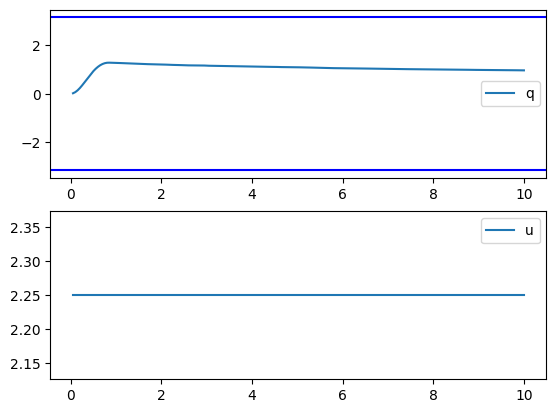

In [48]:
controller_new_policy = PolicyController(new_POLICY, dof=1)
comb_controller = CombinedController(controller1=controller_new_policy, controller2=stabilization_controller,
                                     condition1=condition_policy, condition2=condition_stabilization,
                                     verbose=True, dof=controller_new_policy.dof)

sim = Simulator(pendulum, integrator_name='odeint')
x0 = [0.0, 0.0]
t, x, u = sim.simulate_and_animate(0.0, x0, 10., dt, controller=comb_controller, save_video=True, anim_dt=dt)# t, x, u = sim.simulate(0.0, x0, 5., dt, controller=comb_controller)

t = np.array(t)
x = np.array(x)
u = np.array(u)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, x[:, 0], label='q')
plt.axhline(y = np.pi, color = 'b')
plt.axhline(y = -np.pi, color = 'b')

plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, u, label='u')

plt.legend()

In [51]:
class Controller_pend_swingup(AbstractController):
    def __init__(self, charge_time=1., dof=1):
        super().__init__(dof=dof)
        self.charge_time = charge_time
        
        self.distribution = [[1.]*ACTIONS.shape[0]]*STATES.shape[0] #deterministic

    def get_control_output_(self, x, t=None):
        if t <= self.charge_time:
            return [ACTIONS[0]]
        else:
            return [ACTIONS[1]]
        
pend_swingup_policy = Controller_pend_swingup(charge_time=.8)

stabilization_controller = PController(P=10.)

comb_controller = CombinedController(controller1=pend_swingup_policy, controller2=stabilization_controller,
                                     condition1=condition_policy, condition2=condition_stabilization,
                                     verbose=True, dof=pend_swingup_policy.dof)



Switching to Controller  1 at x= [0. 0.] t= 0.0
Switching to Controller  2 at x= [-2.36432972 -3.5251237 ] t= 1.5500000000000007


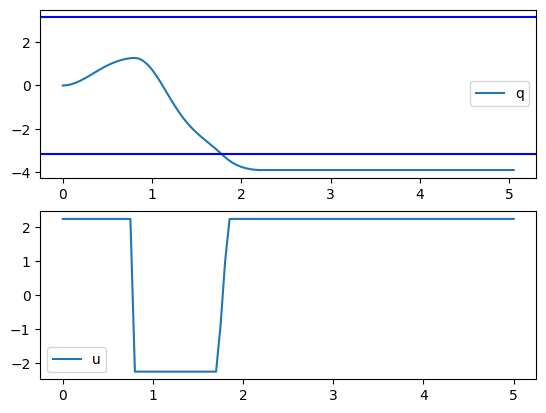

In [53]:
sim = Simulator(pendulum, integrator_name='odeint')
x0 = [0.0, 0.0]
# t, x, u = sim.simulate_and_animate(0.0, x0, 5., dt=0.05, controller=comb_controller, save_video=True, anim_dt=dt)
t, x, u = sim.simulate(0.0, x0, 5., dt=0.05, controller=comb_controller)

t = np.array(t)
x = np.array(x)
u = np.array(u)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, x[:, 0], label='q')
plt.axhline(y = np.pi, color = 'b')
plt.axhline(y = -np.pi, color = 'b')

plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[:-1], u, label='u')
# plt.plot(t, u, label='u')


plt.legend()

Switching to Controller  1 at x= [0. 0.] t= 0


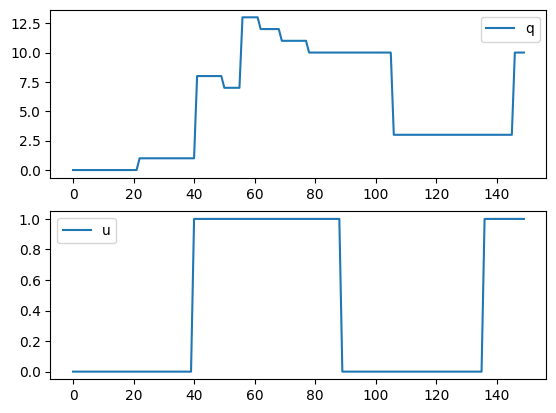

In [54]:

x, u, rewards = simulate(comb_controller, sim, x0, reward_type='normal')
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, label='q')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(u, label='u')
plt.legend()


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.29it/s]

[[ 4.88878417  0.        ]
 [24.48639645 33.66336634]
 [ 0.          0.        ]
 [29.46955075  9.47241725]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-5.78571429  0.        ]
 [-5.80645161 46.42262895]
 [ 0.         38.95671476]
 [ 0.          0.        ]
 [52.96884186 49.76682212]
 [ 0.         66.92563818]
 [ 0.         58.91583452]
 [-5.73913043 52.41264559]]
[[2.122e+03 1.000e+00]
 [1.801e+03 1.010e+02]
 [1.000e+00 1.000e+00]
 [3.005e+03 9.970e+02]
 [1.000e+00 1.000e+00]
 [1.000e+00 1.000e+00]
 [2.800e+01 1.000e+00]
 [3.100e+01 6.010e+02]
 [1.000e+00 9.010e+02]
 [1.000e+00 1.000e+00]
 [1.701e+03 1.501e+03]
 [1.000e+00 9.010e+02]
 [1.000e+00 7.010e+02]
 [2.300e+01 6.010e+02]]


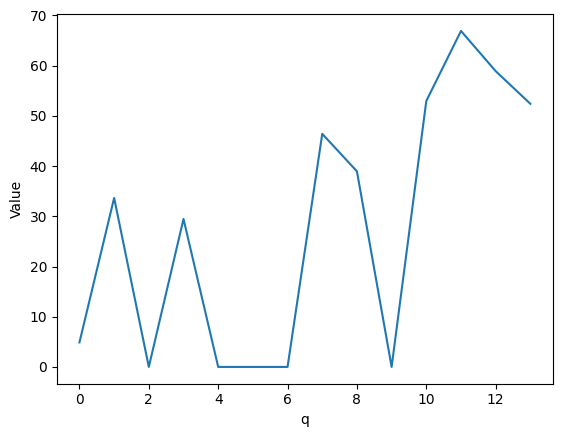

[2.123e+03 1.902e+03 2.000e+00 4.002e+03 2.000e+00 2.000e+00 2.900e+01
 6.320e+02 9.020e+02 2.000e+00 3.202e+03 9.020e+02 7.020e+02 6.240e+02]


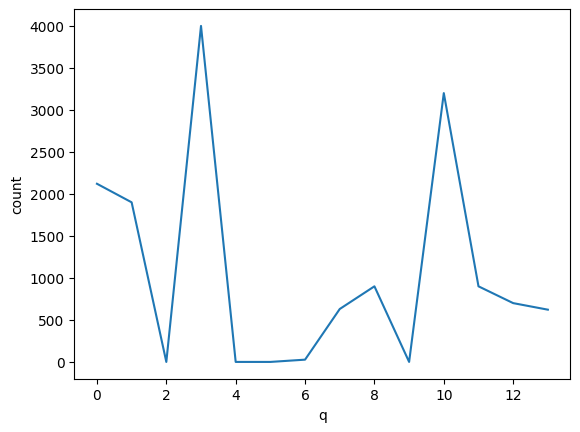

In [55]:
state_action_on_policy, states_actions_count = monte_carlo_on_policy(sim, comb_controller, episodes=100, reward_type='normal')
state = np.max(state_action_on_policy, axis=-1)

print(state_action_on_policy)
print(states_actions_count)

plt.figure('Estimate of value function')
plt.plot(state)
plt.ylabel('Value')
plt.xlabel('q')
plt.show()
plt.close()

state_cnt = np.sum(states_actions_count, axis=-1)
print(state_cnt)

plt.figure('Visited states')
plt.plot(state_cnt)
plt.ylabel('count')
plt.xlabel('q')
plt.show()
plt.close()



In [56]:
new_POLICY = np.argmax(state_action_on_policy, axis=-1)
new_POLICY = [ACTIONS[p] for p in new_POLICY]
print(new_POLICY)

[2.25, -2.25, 2.25, 2.25, 2.25, 2.25, -2.25, -2.25, -2.25, 2.25, 2.25, -2.25, -2.25, -2.25]


Saving video to pendulum_swingup.mp4
Switching to Controller  2 at x= [-2.4102477  -1.54409893] t= 1.4500000000000006
Saving video done.


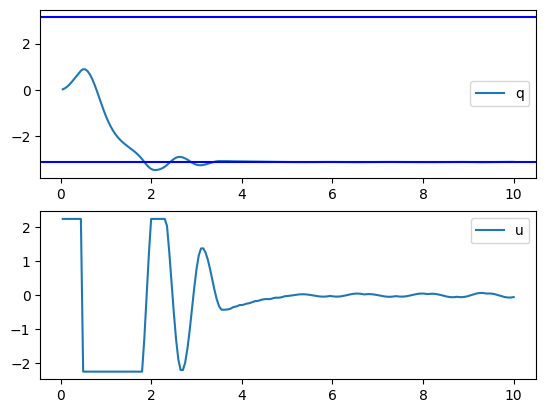

In [57]:
controller_new_policy = PolicyController(new_POLICY, dof=1)
comb_controller = CombinedController(controller1=controller_new_policy, controller2=stabilization_controller,
                                     condition1=condition_policy, condition2=condition_stabilization,
                                     verbose=True, dof=pend_swingup_policy.dof)

sim = Simulator(pendulum, integrator_name='odeint')
x0 = [0.0, 0.0]
t, x, u = sim.simulate_and_animate(0.0, x0, 10., dt, controller=comb_controller, save_video=True, anim_dt=dt)# t, x, u = sim.simulate(0.0, x0, 5., dt, controller=comb_controller)

t = np.array(t)
x = np.array(x)
u = np.array(u)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, x[:, 0], label='q')
plt.axhline(y = np.pi, color = 'b')
plt.axhline(y = -np.pi, color = 'b')

plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, u, label='u')

plt.legend()

In [58]:
# Monte Carlo Sample with Off-Policy
def monte_carlo_off_policy(sim, behavior, controller, episodes, reward_type='normal'):
    states_actions = np.zeros((STATES.shape[0], ACTIONS.shape[0]))
    states_actions_count = np.zeros((STATES.shape[0], ACTIONS.shape[0]))
    
    C = np.zeros((STATES.shape[0], ACTIONS.shape[0]))
    
    for i in tqdm(range(0, episodes)):
        x0 = np.random.normal([0.]*2, [0.01]*2)
        x, u, rewards = simulate(behavior, sim, x0, reward_type=reward_type, T=2.)

        G = 0
        W = 1
        for state, action, reward in zip(x[::-1], u[::-1], rewards[::-1]):
            G += reward
            C[state, action] += W
            
            states_actions[state, action] += (W / C[state, action]) * (G - states_actions[state, action])
            states_actions_count[state, action] += 1
            
            if action == controller.POLICY[state]:
                W = W / behavior.distribution[state, action]
            else:
                break # very important to stop when W = 0
            
    return states_actions, states_actions_count

  0%|▋                                                                                                                                                                                    | 4/1000 [00:00<01:09, 14.31it/s]/home/niccoloturcato/anaconda3/envs/pytorch/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:13<00:00, 13.69it/s]


[[-1. -1.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [-1. -1.]
 [-1. -1.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [-1. -1.]]


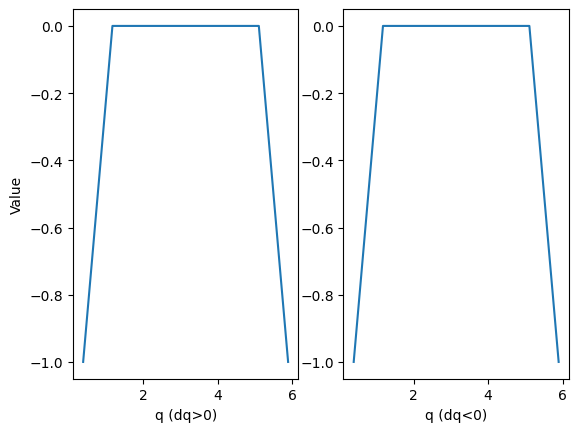

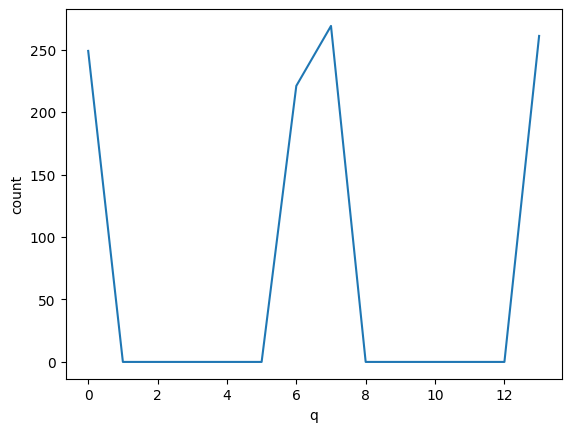

In [59]:
state_action_off_policy, states_actions_count = monte_carlo_off_policy(sim, rand_policy, controller_fix_policy, episodes=1000, reward_type='normal')
state = np.max(state_action_off_policy, axis=-1)

print(state_action_off_policy)
# print(states_actions_count)

plt.figure('Estimate of value function')
plt.subplot(1,2,1)
plt.plot(STATES[:int(STATES.shape[0]/2), 0]+q_1/2, state[:int(state.shape[0]/2)])
plt.ylabel('Value')
plt.xlabel('q (dq>0)')
plt.subplot(1,2,2)
plt.plot(STATES[int(STATES.shape[0]/2):, 0]+q_1/2, state[int(state.shape[0]/2):])
plt.xlabel('q (dq<0)')
plt.show()
plt.close()

state_cnt = np.sum(states_actions_count, axis=-1)
# print(state_cnt)

plt.figure('Visited states')
plt.plot(state_cnt)
plt.ylabel('count')
plt.xlabel('q')
plt.show()
plt.close()

In [60]:
new_POLICY = np.argmax(state_action_off_policy, axis=-1)
new_POLICY = [ACTIONS[p] for p in new_POLICY]
print(new_POLICY)

[2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25]


Saving video to pendulum_swingup.mp4
Saving video done.


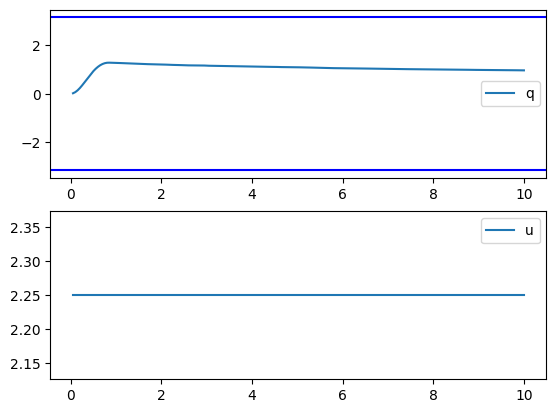

In [61]:
controller_new_policy = PolicyController(new_POLICY, dof=1)
comb_controller = CombinedController(controller1=controller_new_policy, controller2=stabilization_controller,
                                     condition1=condition_policy, condition2=condition_stabilization,
                                     verbose=True, dof=pend_swingup_policy.dof)
x0 = [0.0, 0.0]

sim = Simulator(pendulum, integrator_name='odeint')
t, x, u = sim.simulate_and_animate(0.0, x0, 10., dt, controller=comb_controller, save_video=True, anim_dt=dt)
# t, x, u = sim.simulate(0.0, x0, 5., dt, controller=comb_controller)

t = np.array(t)
x = np.array(x)
u = np.array(u)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, x[:, 0], label='q')
plt.axhline(y = np.pi, color = 'b')
plt.axhline(y = -np.pi, color = 'b')

plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, u, label='u')

plt.legend()


  0%|▎                                                                                                                                                                                    | 2/1000 [00:00<01:11, 13.97it/s]/home/niccoloturcato/anaconda3/envs/pytorch/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:13<00:00, 13.68it/s]


[[-1. -1.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [-1. -1.]
 [-1. -1.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [-1. -1.]]
[[112. 121.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [119. 129.]
 [145. 128.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [108. 138.]]


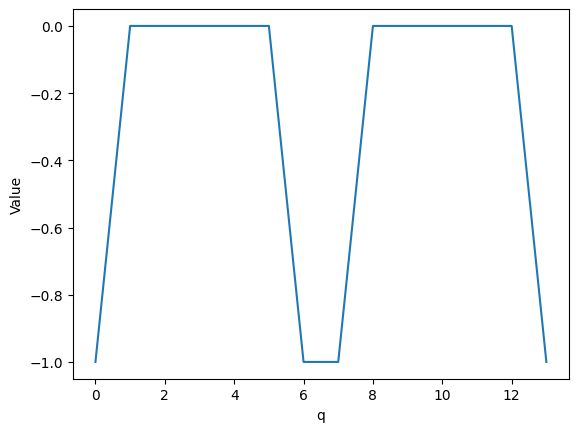

[233.   0.   0.   0.   0.   0. 248. 273.   0.   0.   0.   0.   0. 246.]


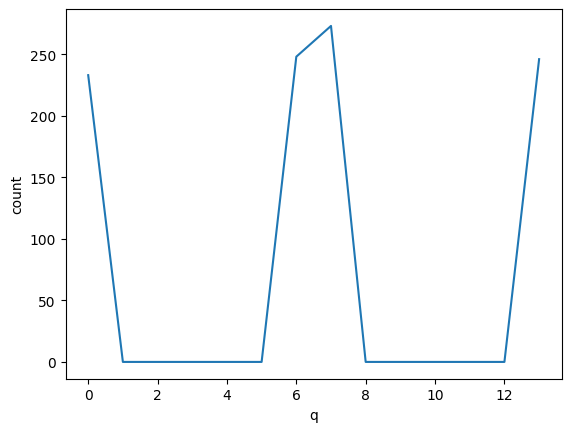

[2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25]


/home/niccoloturcato/anaconda3/envs/pytorch/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2850000000000D+01   r2 =  0.1240858857456D-08
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2900000000000D+01   r2 =  0.1258849534697D-08
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2950000000000D+01   r2 =  0.1276694239214D-08
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3000000000000D+01   r2 =  0.1294392510219D-08
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      

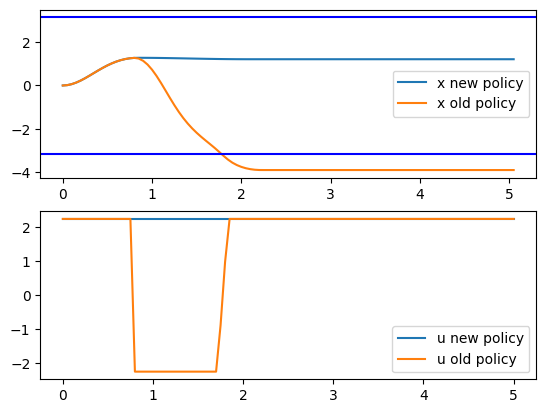

In [62]:
pend_swingup_policy = Controller_pend_swingup(charge_time=.8)

state_action_off_policy, states_actions_count = monte_carlo_off_policy(sim, rand_policy, controller_fix_policy, episodes=1000, reward_type='normal')
state = np.max(state_action_off_policy, axis=-1)

print(state_action_off_policy)
print(states_actions_count)

plt.figure('Estimate of value function')
plt.plot(state)
plt.ylabel('Value')
plt.xlabel('q')
plt.show()
plt.close()

state_cnt = np.sum(states_actions_count, axis=-1)
print(state_cnt)

plt.figure('Visited states')
plt.plot(state_cnt)
plt.ylabel('count')
plt.xlabel('q')
plt.show()
plt.close()


new_POLICY = np.argmax(state_action_off_policy, axis=-1)
new_POLICY = [ACTIONS[p] for p in new_POLICY]
print(new_POLICY)

controller_new_policy = PolicyController(new_POLICY, dof=1)
comb_controller = CombinedController(controller1=controller_new_policy, controller2=stabilization_controller,
                                     condition1=condition_policy, condition2=condition_stabilization,
                                     verbose=True, dof=controller_new_policy.dof)
x0 = [0.0, 0.0]

sim = Simulator(pendulum, integrator_name='odeint')
# t, x, u = sim.simulate_and_animate(0.0, x0, 10., dt, controller=comb_controller, save_video=True, anim_dt=dt)
t, x, u = sim.simulate(0.0, x0, 5., dt, controller=comb_controller)

comb_pend_swingup_controller = CombinedController(controller1=pend_swingup_policy, controller2=stabilization_controller,
                                     condition1=condition_policy, condition2=condition_stabilization,
                                     verbose=True, dof=pend_swingup_policy.dof)
t_1, x_1, u_1 = sim.simulate(0.0, x0, 5., dt, controller=comb_pend_swingup_controller)

t = np.array(t)
x = np.array(x)
u = np.array(u)

t_1 = np.array(t_1)
x_1 = np.array(x_1)
u_1 = np.array(u_1)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, x[:, 0], label='x new policy')
plt.plot(t_1, x_1[:, 0], label='x old policy')
plt.axhline(y = np.pi, color = 'b')
plt.axhline(y = -np.pi, color = 'b')

plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[:-1], u, label='u new policy')
plt.plot(t_1[:-1], u_1, label='u old policy')

plt.legend()


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:12<00:00, 13.86it/s]


[[-2.99736855 -2.99868928]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-2.99777073 -2.99340828]
 [-3.01008581 -2.97811761]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-2.99469763 -2.97811109]]
[[147. 110.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [115. 127.]
 [132. 116.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [121. 132.]]


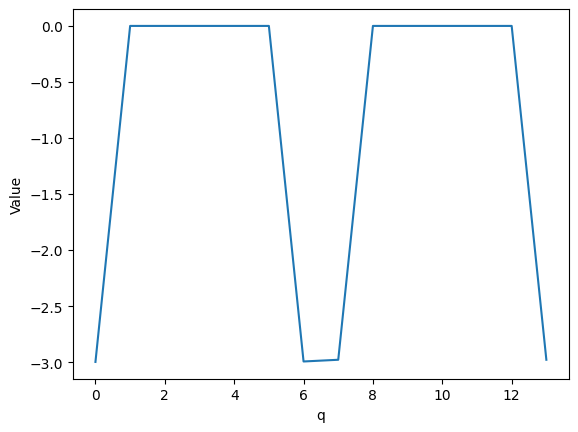

[257.   0.   0.   0.   0.   0. 242. 248.   0.   0.   0.   0.   0. 253.]


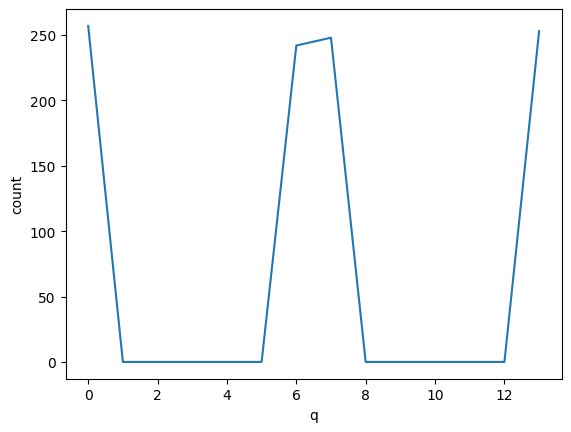

[2.25, 2.25, 2.25, 2.25, 2.25, 2.25, -2.25, -2.25, 2.25, 2.25, 2.25, 2.25, 2.25, -2.25]
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2850000000000D+01   r2 =  0.1240858857456D-08
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2900000000000D+01   r2 =  0.1258849534697D-08
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2950000000000D+01   r2 =  0.1276694239214D-08
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3000000000000D+01   r2 =  0.1294392510219D-08
 lsoda--  at t (=r1) and step size h (=r2), the      
      

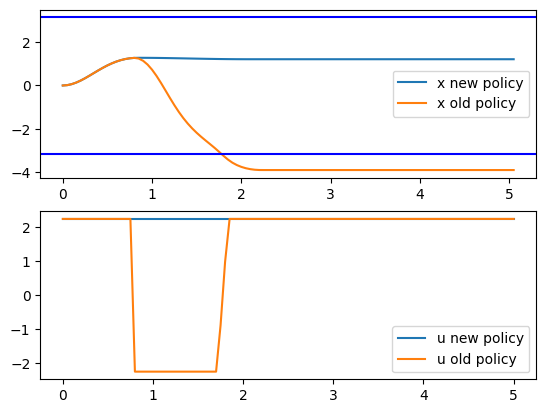

In [63]:
pend_swingup_policy = Controller_pend_swingup(charge_time=.8)

state_action_off_policy, states_actions_count = monte_carlo_off_policy(sim, rand_policy, controller_fix_policy, episodes=1000, reward_type='shaping')
state = np.max(state_action_off_policy, axis=-1)

print(state_action_off_policy)
print(states_actions_count)

plt.figure('Estimate of value function')
plt.plot(state)
plt.ylabel('Value')
plt.xlabel('q')
plt.show()
plt.close()

state_cnt = np.sum(states_actions_count, axis=-1)
print(state_cnt)

plt.figure('Visited states')
plt.plot(state_cnt)
plt.ylabel('count')
plt.xlabel('q')
plt.show()
plt.close()


new_POLICY = np.argmax(state_action_off_policy, axis=-1)
new_POLICY = [ACTIONS[p] for p in new_POLICY]
print(new_POLICY)

controller_new_policy = PolicyController(new_POLICY, dof=1)
comb_controller = CombinedController(controller1=controller_new_policy, controller2=stabilization_controller,
                                     condition1=condition_policy, condition2=condition_stabilization,
                                     verbose=True, dof=controller_new_policy.dof)
x0 = [0.0, 0.0]

sim = Simulator(pendulum, integrator_name='odeint')
# t, x, u = sim.simulate_and_animate(0.0, x0, 10., dt, controller=comb_controller, save_video=True, anim_dt=dt)
t, x, u = sim.simulate(0.0, x0, 5., dt, controller=comb_controller)

comb_pend_swingup_controller = CombinedController(controller1=pend_swingup_policy, controller2=stabilization_controller,
                                     condition1=condition_policy, condition2=condition_stabilization,
                                     verbose=True, dof=pend_swingup_policy.dof)
t_1, x_1, u_1 = sim.simulate(0.0, x0, 5., dt, controller=comb_pend_swingup_controller)

t = np.array(t)
x = np.array(x)
u = np.array(u)

t_1 = np.array(t_1)
x_1 = np.array(x_1)
u_1 = np.array(u_1)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, x[:, 0], label='x new policy')
plt.plot(t_1, x_1[:, 0], label='x old policy')
plt.axhline(y = np.pi, color = 'b')
plt.axhline(y = -np.pi, color = 'b')

plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[:-1], u, label='u new policy')
plt.plot(t_1[:-1], u_1, label='u old policy')

plt.legend()
